# **Introduction**

This is an initial Explanatory Data Analysis for the [Mercari Price Suggestion Challenge](https://www.kaggle.com/c/mercari-price-suggestion-challenge#description) with matplotlib. [bokeh](https://bokeh.pydata.org/en/latest/) and [Plot.ly](https://plot.ly/feed/) - a visualization tool that creates beautiful interactive plots and dashboards.  The competition is hosted by Mercari, the biggest Japanese community-powered shopping app with the main objective to predict an accurate price that Mercari should suggest to its sellers, given the item's information. 

***Update***: The abundant amount of food from my family's Thanksgiving dinner has really energized me to continue working on this model. I decided to dive deeper into the NLP analysis and found an amazing tutorial by Ahmed BESBES. The framework below is  based on his [source code](https://ahmedbesbes.com/how-to-mine-newsfeed-data-and-extract-interactive-insights-in-python.html).  It provides guidance on pre-processing documents and  machine learning techniques (K-means and LDA) to clustering topics.  So that this kernel will be divided into 2 parts: 

1. Explanatory Data Analysis 
2. Text Processing  
    2.1. Tokenizing and  tf-idf algorithm  
    2.2. K-means Clustering  
    2.3. Latent Dirichlet Allocation (LDA)  / Topic Modelling
 

In [1]:
import nltk
import string
import re
import numpy as np
import pandas as pd
import pickle
#import lda

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook
#from bokeh.transform import factor_cmap

import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("lda").setLevel(logging.WARNING)
import tokenize

# **Exploratory Data Analysis**
On the first look at the data, besides the unique identifier (item_id), there are 7 variables in this model. This notebook will sequentially go through each of them with a brief statistical summary. 

1. **Numerical/Continuous Features**
    1. price: the item's final bidding price. This will be our reponse / independent variable that we need to predict in the test set
    2. shipping cost     
 
1. **Categorical Features**: 
    1. shipping cost: A binary indicator, 1 if shipping fee is paid by seller and 0 if it's paid by buyer
    2. item_condition_id: The condition of the items provided by the seller
    1. name: The item's name
    2. brand_name: The item's producer brand name
    2. category_name: The item's single or multiple categories that are separated by "\" 
    3. item_description: A short description on the item that may include removed words, flagged by [rm]

In [2]:
train1 = pd.read_csv('/Users/muratyalcin/Desktop/Data Science/Kaggle/Mercari Price Suggestion Challenge/train.tsv', sep='\t')

In [3]:
test1 = pd.read_csv('/Users/muratyalcin/Desktop/Data Science/Kaggle/Mercari Price Suggestion Challenge/test.tsv', sep='\t')

In [20]:
train=train1
test=test1

In [5]:
# size of training and dataset
print(train.shape)
print(test.shape)

(1482535, 8)
(693359, 7)


In [12]:
# different data types in the dataset: categorical (strings) and numeric
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [13]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693359 entries, 0 to 693358
Data columns (total 7 columns):
test_id              693359 non-null int64
name                 693359 non-null object
item_condition_id    693359 non-null int64
category_name        690301 non-null object
brand_name           397834 non-null object
shipping             693359 non-null int64
item_description     693359 non-null object
dtypes: int64(3), object(4)
memory usage: 37.0+ MB


## Target Variable: **Price**

The next standard check is with our response or target variables, which in this case is the `price` we are suggesting to the Mercari's marketplace sellers.  The median price of all the items in the training is about \$26.7 but given the existence of some extreme values of over \$100 and the maximum at \$2,009, the distribution of the variables is heavily skewed to the left. So let's make log-transformation on the price (we added +1 to the value before the transformation to avoid zero and negative values).

In [111]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

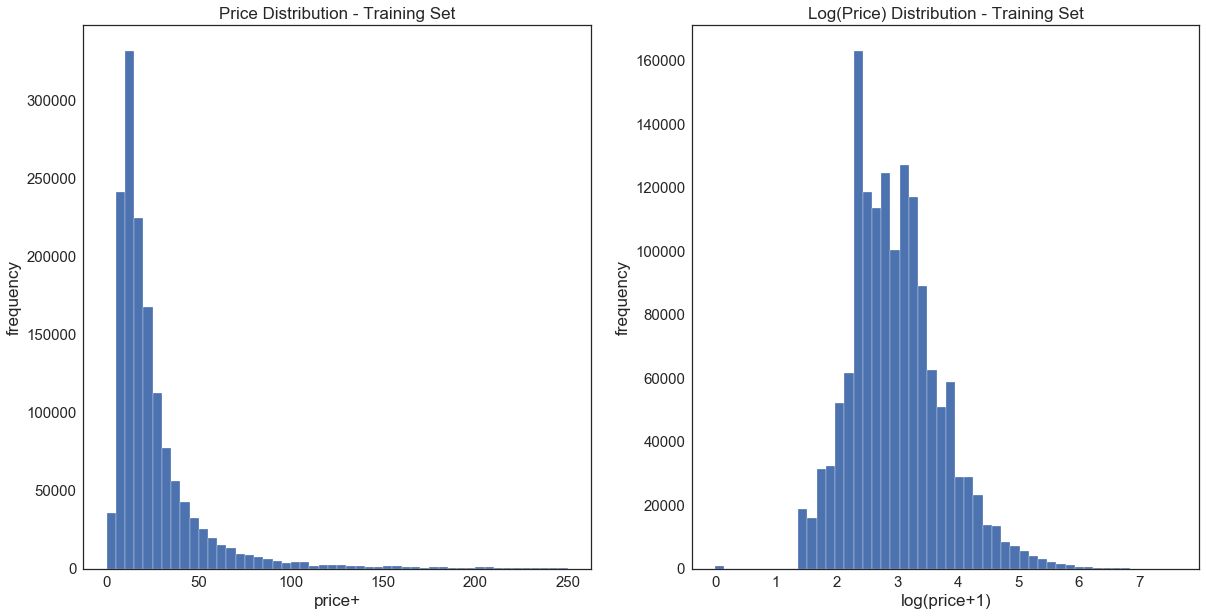

In [16]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(20,10), edgecolor='white',range=[0,250])
plt.xlabel('price+', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)

plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(20,10), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Training Set', fontsize=17)
plt.show()

## **Item Category**

There are about **1,287** unique categories but among each of them, we will always see a main/general category firstly, followed by two more particular subcategories (e.g. Beauty/Makeup/Face or Lips). In adidition, there are about 6,327 items that do not have a category labels. Let's split the categories into three different columns. We will see later that this information is actually quite important from the seller's point of view and how we handle the missing information in the `brand_name` column will impact the model's prediction. 

In [128]:
print("There are %d unique values in the category column." % train['category_name'].nunique())

There are 1287 unique values in the category column.


In [129]:
# TOP 5 RAW CATEGORIES
train['category_name'].value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Name: category_name, dtype: int64

In [130]:
# missing categories
print("There are %d items that do not have a label." % train['category_name'].isnull().sum())

There are 6327 items that do not have a label.


In [21]:
# reference: BuryBuryZymon at https://www.kaggle.com/maheshdadhich/i-will-sell-everything-for-free-0-55
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")
    #except: return ("Null", "Null", "Null")

In [22]:
train['general_cat'], train['subcat_1'], train['subcat_2'] = \
zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [19]:
train.category_name.head(5)

0                                    Men/Tops/T-shirts
1    Electronics/Computers & Tablets/Components & P...
2                          Women/Tops & Blouses/Blouse
3                   Home/Home Décor/Home Décor Accents
4                              Women/Jewelry/Necklaces
Name: category_name, dtype: object

In [20]:
print("There are %d items that do not have a general cat." % train['general_cat'].isnull().sum())

There are 0 items that do not have a general cat.


In [21]:
print("There are %d items that do not have a price." % train['price'].isnull().sum())

There are 0 items that do not have a price.


In [22]:
print("There are %d items that do not have a brand name." % train['brand_name'].isnull().sum())

There are 632682 items that do not have a brand name.


In [23]:
print("There are %d unique brand names" % train['brand_name'].nunique())

There are 4809 unique brand names


In [24]:
train.general_cat.value_counts()

Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
No Label                    6327
Name: general_cat, dtype: int64

In [25]:
Men_Mean = train.groupby(['general_cat']).mean()['price']['Men']
Men_Mean

34.708614432109307

In [26]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [27]:
a=train[train.general_cat=='Men']['price']

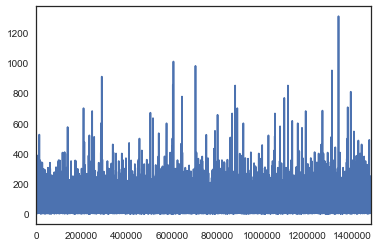

In [28]:
a.plot()

In [8]:
# repeat the same step for the test set
test['general_cat'], test['subcat_1'], test['subcat_2'] = \
zip(*test['category_name'].apply(lambda x: split_cat(x)))

In [31]:
print("There are %d unique general-categories." % train['general_cat'].nunique())

There are 11 unique general-categories.


In [32]:
print("There are %d unique first sub-categories." % train['subcat_1'].nunique())

There are 114 unique first sub-categories.


In [33]:
print("There are %d unique second sub-categories." % train['subcat_2'].nunique())

There are 871 unique second sub-categories.


In [9]:
train.groupby('brand_name').agg({'price':['min', 'max', 'count' ,'mean','median']}).sort_values(by=('price','count'),ascending=False).head(100)

price                                 
                            min     max  count       mean median
brand_name                                                      
PINK                        0.0   798.0  54088  26.341314   20.0
Nike                        0.0   459.0  54043  30.760265   22.0
Victoria's Secret           0.0  1400.0  48036  23.214287   19.0
LuLaRoe                     0.0   350.0  31024  33.667967   29.0
Apple                       0.0  1909.0  17322  73.268618   22.0
FOREVER 21                  0.0   180.0  15186  12.929935   12.0
Nintendo                    0.0   600.0  15007  34.672619   20.0
Lululemon                   0.0   711.0  14558  47.096717   39.0
Michael Kors                0.0  1770.0  13928  62.254775   49.0
American Eagle              0.0   210.0  13254  15.960955   14.0
Rae Dunn                    0.0   490.0  12305  37.170581   30.0
Sephora                     0.0   613.0  12172  21.820613   16.0
Coach                       0.0   720.0  10463  41.142550   31.0
Disney                      0.0   506.0  10360  17.146670   13.0
Bath & Body Works           0.0   565.0  10354  17.905737   14.0
Adidas                      0.0   950.0  10202  43.127328   25.0
Funko                       0.0   775.0   9237  29.054888   20.0
Under Armour                0.0   356.0   8461  19.367923   16.0
Sony                        0.0   750.0   7994  35.466662   19.0
Old Navy                    0.0   150.0   7567  12.796022   11.0
Hollister                   0.0   140.0   6948  14.848158   13.0
Carter's                    0.0   200.0   6385  13.924902   11.0
Urban Decay                 0.0  1515.0   6210  22.973430   19.0
The North Face              0.0   256.0   6172  36.077447   30.0
Independent                 0.0   604.0   5902  36.716367   33.0
Too Faced                   0.0   837.0   5794  22.477304   19.0
Xbox                        0.0  1115.0   5709  30.477141   17.0
Brandy Melville             0.0   310.0   5680  18.831690   16.0
Kate Spade                  0.0   340.0   5411  57.979948   46.0
MAC                         3.0   575.0   5302  21.899000   16.0
...                         ...     ...    ...        ...    ...
Columbia                    0.0   134.0   2035  20.548894   18.0
Fitbit                      3.0   194.0   2028  56.747041   50.0
Kat Von D                   0.0   389.0   2016  23.863839   19.5
Bebe                        3.0   210.0   1967  24.237926   20.0
GUESS                       0.0   150.0   1936  20.543388   16.0
Customized & Personalized   0.0   500.0   1931  34.222683   25.0
ALEX AND ANI                0.0   465.0   1931  22.446919   19.0
American Girl ®             0.0   415.0   1918  37.574035   25.0
Urban Outfitters            0.0   120.0   1881  17.614833   15.0
Rock Revival                0.0   284.0   1876  57.295842   55.0
Betsey Johnson              0.0   200.0   1868  25.237152   21.0
Target                      3.0   197.0   1868  15.047109   12.0
Jordan                      0.0   520.0   1863  71.042405   55.0
Gucci                       4.0  1325.0   1857  97.070005   64.0
Ray-Ban                     0.0   210.0   1842  50.524430   50.0
patagonia                   6.0   230.0   1807  47.498063   45.0
Harley-Davidson             0.0   409.0   1790  27.003352   19.0
Reebok                      0.0   240.0   1786  23.438970   19.0
Mattel®                     0.0   180.0   1778  21.311024   16.0
Clinique                    0.0   271.0   1770  16.732768   14.0
Gymboree                    3.0   200.0   1760  16.488068   12.0
Dooney & Bourke             5.0   406.0   1751  60.342090   41.0
vineyard vines              0.0   221.0   1712  24.867407   21.0
Juicy Couture               0.0   166.0   1706  22.404455   19.0
Xhilaration                 3.0    77.0   1690  11.976923   11.0
PUMA                        0.0   264.0   1683  46.588829   31.0
NFL                         0.0   341.0   1675  14.673433   11.0
Maybelline                  3.0    74.0   1666   9.616447    

It is benefical for our analysis to convert brand to dummy variable.

In [ ]:
train.groupby('name').agg({'price':['min', 'max', 'count' ,'mean','median']}).sort_values(by=('price','mean'),ascending=False)

There is no benefit of keeping name column, because we can not get any helpful insight from it

In [ ]:
train.groupby('general_cat').agg({'price':['min', 'max', 'count' ,'mean']}).sort_values(by=('price','mean'),ascending=False)

In [44]:
len(train[(train.price >1000)])

167

In [45]:
len(train[(train.price >750)])

419

In [46]:
len(train[(train.price >500)])

1115

As we see, we have serious outliers in our data. Removing outliers is a one way handle with them. But need to be very careful.

In [40]:
len(train)

1482535

In [23]:
expensiveitems = train[(train.price >1000)]

In [24]:
expensiveitems.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
1971,1971,Chanel Classic Flag Bag medium Caviar L,3,Women/Women's Handbags/Shoulder Bag,Chanel,1506.0,0,No description yet,Women,Women's Handbags,Shoulder Bag
15769,15769,Celine Tri Colored Suede Mini luggage,3,Women/Women's Handbags/Totes & Shoppers,Celine,1009.0,0,Beautiful Celine mini luggage. In good conditi...,Women,Women's Handbags,Totes & Shoppers
19599,19599,Alexander McQueen Crystal Knuckle Clutch,1,Vintage & Collectibles/Bags and Purses/Clutch,Alexander McQueen,1109.0,0,Alexander McQueen Knuckle Duster Multi Color C...,Vintage & Collectibles,Bags and Purses,Clutch
19621,19621,"Tiffany wedding band originally [rm],000",3,Women/Jewelry/Rings,Tiffany & Co.,1004.0,0,Tiffany's wedding band selling for half the pr...,Women,Jewelry,Rings
21693,21693,YSL purse and shoes combo,1,Women/Women's Handbags/Shoulder Bag,Saint Laurent,1206.0,0,YSL small monogram purse (new) and skate shoes...,Women,Women's Handbags,Shoulder Bag


In [27]:
expensiveitems.groupby('subcat_2').size()

subcat_2
Backpack Style                   1
Backpacks, Bags & Briefcases     1
Cell Phone Accessories           1
Cell Phones & Smartphones        2
Clutch                           1
Consoles                         1
Digital Cameras                  2
Earrings                         1
Face                             1
Games                            1
Handbag                         22
Headphones                       1
Hobo                             3
Laptops & Netbooks              15
Luggage                          2
Makeup Palettes                  3
Makeup Sets                      1
Messenger & Crossbody           12
Necklaces                        1
Other                            2
Panties                          1
Purse                            1
Rings                           12
Satchel                          3
Scarves & Wraps                  1
Shoulder Bag                    47
T-Shirts                         1
Totes & Shoppers                18
Trench     

In [14]:
expensiveitems.groupby('brand_name').size()

brand_name
Alexander McQueen     1
Apple                16
Benefit               1
Bose                  1
Burberry              1
Canon                 2
Cartier               1
Celine                5
Chanel               21
David Yurman          1
Dell                  1
Goyard                1
Gucci                 4
Louis Vuitton        60
MCM Worldwide         6
Mary Kay              1
Michael Kors          2
Microsoft             2
Oakley                1
Prada                 1
Proenza Schouler      1
Saint Laurent         8
Stamped               1
Tiffany & Co.         1
Urban Decay           3
Victoria's Secret     1
Vintage               1
Xbox                  1
dtype: int64

In [49]:
train.groupby('subcat_2').agg({'price':['min', 'max', 'count' ,'mean']}).sort_values(by=('price','mean'),ascending=False)

price                          
                              min     max count        mean
subcat_2                                                   
Laptops & Netbooks            3.0  1708.0  1783  177.089176
Standard                     19.0   480.0    15  163.666667
Desktops & All-In-Ones        6.0   900.0   170  149.329412
Handbag                       0.0  1709.0  1367  139.562546
Travel Systems                3.0   590.0    90  124.600000
Air Conditioners              9.0   186.0    42  121.142857
Lightweight                  17.0   385.0    18  117.111111
Digital Cameras               3.0  1056.0  1346  112.305349
Satchel                       0.0  1800.0  2333  111.624518
Cell Phones & Smartphones     0.0  1254.0  8698  109.109508
Brass Instruments             7.0   615.0    18   97.833333
Wind & Woodwind Instruments   5.0   900.0    73   94.753425
Consoles                      0.0  1115.0  4209   90.155144
Oils & Fluids                42.0   135.0     3   87.333333
Vacuums & Floor Care          5.0   435.0   216   86.523148
Women's Golf Clubs            8.0   135.0     4   85.750000
Lenses & Filters              5.0   850.0   197   82.832487
Men's Golf Clubs              3.0   575.0   225   81.226667
Music                        12.0   425.0     8   78.500000
Car Subwoofers               15.0   205.0    21   76.095238
Band & Orchestra              4.0   290.0     8   75.875000
Formal                       11.0   225.0    51   74.313725
iPad                          0.0  1900.0  3059   73.583851
Home Surveillance             5.0   609.0   170   73.241176
Electronics for Kids          0.0   359.0   746   72.848525
Hobo                          0.0  1480.0   323   71.761610
Bass Guitars                 20.0   135.0     5   70.800000
Flashes & Flash Accessories   7.0   250.0    11   70.636364
Luggage                       5.0  1015.0   418   69.456938
Parka                         8.0   626.0   325   67.126154
...                           ...     ...   ...         ...
Exterior Accessories          3.0   110.0   697    8.642755
Office                        5.0    12.0     2    8.500000
Postcard                      3.0    27.0    20    8.400000
Magnets                       3.0    16.0    31    8.258065
Tweezers                      3.0    24.0    96    8.177083
Art                           3.0    36.0    88    8.068182
Doorstops                     8.0     8.0     1    8.000000
Safety Caps                   6.0    10.0     2    8.000000
Electrical Safety             4.0    10.0     8    8.000000
Kids' Bath                    5.0    14.0     4    8.000000
Screen Protectors             3.0    88.0  2152    7.840149
Handmade                      4.0    14.0     4    7.750000
Scifi                         5.0    10.0     3    7.666667
Collages                      4.0    10.0     3    7.666667
Draft Stoppers                7.0     7.0     2    7.000000
Magnet                        4.0    12.0    18    6.777778
Pinback Button                0.0    35.0   296    6.719595
Animals                       6.0     7.0     2    6.500000
Carving                       6.0     7.0     2    6.500000
Sticker                       3.0   150.0  4117    6.069711
Dishwashers                   6.0     6.0     1    6.000000
Coasters                      4.0     8.0     3    6.000000
Ephemera                      6.0     6.0     1    6.000000
Doll Clothes                  6.0     6.0     1    6.000000
Cotton & Swabs                5.0     7.0     3    6.000000
Graphic Design                3.0     8.0    11    6.000000
Patch                         3.0    40.0   829    5.560917
Books and Zines               3.0     8.0     2    5.500000
Mirror                        5.0     5.0     1    5.000000
Artist Bears                  5.0     5.0     1    5.000000

[871 rows x 4 columns]

Using sub category 2 makes more sense than using general and sub category 1

In [50]:
train.groupby('brand_name').agg({'price':['min', 'max', 'count' ,'mean']}).sort_values(by=('price','mean'),ascending=False)

price                          
                             min     max count        mean
brand_name                                                
Demdaco                     10.0   848.0     2  429.000000
Proenza Schouler            16.0  1006.0     4  413.250000
Auto Meter                 344.0   344.0     1  344.000000
Oris                       300.0   300.0     1  300.000000
MCM Worldwide               11.0  1359.0    69  289.173913
Longines                   254.0   254.0     1  254.000000
Vitamix                     16.0   640.0     9  253.111111
Blendtec                   134.0   415.0     5  251.800000
David Yurman                 7.0  2004.0   242  248.611570
Celine                      12.0  1806.0    73  238.780822
Saint Laurent                3.0  1700.0   128  232.578125
Canada Goose                 8.0   608.0    16  230.250000
Dainese                    230.0   230.0     1  230.000000
Valentino Garavani          72.0   526.0     6  227.000000
Frédérique Constant        224.0   224.0     1  224.000000
Mackage                     91.0   450.0     3  221.000000
MICHELE                     10.0   906.0    59  216.983051
Tag Heuer                   58.0   400.0     8  206.125000
Alexander Wang              15.0   489.0    37  205.702703
iRobot                     125.0   284.0     2  204.500000
Contours                   195.0   215.0     3  203.333333
EVGA                       136.0   286.0     3  202.666667
Louis Vuitton                3.0  1815.0  3187  202.187637
Brioni                     200.0   200.0     1  200.000000
Alyce Paris                200.0   200.0     1  200.000000
Stephen Webster            200.0   200.0     1  200.000000
Stuart Weitzman              5.0   679.0    60  198.716667
Valentino                   11.0   909.0    96  191.083333
Mikimoto                   120.0   306.0     3  189.000000
Christian Louboutin          9.0   650.0   360  188.444444
...                          ...     ...   ...         ...
Rosewill                     4.0     4.0     1    4.000000
Renu                         4.0     4.0     1    4.000000
Babyhome                     4.0     4.0     1    4.000000
First Wave                   4.0     4.0     1    4.000000
Anita                        4.0     4.0     1    4.000000
Eminence                     4.0     4.0     1    4.000000
Bio Spot                     4.0     4.0     1    4.000000
HDE                          4.0     4.0     1    4.000000
Hershey                      4.0     4.0     1    4.000000
EK Success                   4.0     4.0     1    4.000000
Workman                      3.0     4.0     2    3.500000
Kids Only                    3.0     3.0     1    3.000000
Feetures!                    3.0     3.0     1    3.000000
A.B.S. by Allen Schwartz     3.0     3.0     1    3.000000
Old Glory                    3.0     3.0     1    3.000000
Pedialyte                    3.0     3.0     1    3.000000
AA Aquarium                  3.0     3.0     1    3.000000
Ask                          3.0     3.0     1    3.000000
Peanut Shell                 3.0     3.0     1    3.000000
Archie Comics                3.0     3.0     1    3.000000
Revlon Colorsilk             3.0     3.0     1    3.000000
Twilight Gypsy Collective    3.0     3.0     1    3.000000
DUO                          3.0     3.0     1    3.000000
Ergodyne                     3.0     3.0     1    3.000000
Genica                       3.0     3.0     1    3.000000
Scunci                       3.0     3.0     1    3.000000
Play MG                      3.0     3.0     1    3.000000
Kae Argatherapie             3.0     3.0     1    3.000000
Gossip Girl                  0.0     0.0     1    0.000000
CM Style Fashion             0.0     0.0     1    0.000000

[4809 rows x 4 columns]

In [41]:
train.groupby('general_cat')['price'].mean()

general_cat
Beauty                    19.671536
Electronics               35.173922
Handmade                  18.156572
Home                      24.536599
Kids                      20.642315
Men                       34.708614
No Label                  25.394658
Other                     20.809817
Sports & Outdoors         25.532219
Vintage & Collectibles    27.339426
Women                     28.885496
Name: price, dtype: float64

General category doesn't tell us much about the data

In [52]:
subcat1mean=train.groupby('subcat_1')['price'].mean()
subcat1mean

subcat_1
Accessories                  18.897358
Antique                      24.739373
Apparel                      16.386566
Art                          14.748476
Artwork                      13.996440
Athletic Apparel             28.460940
Automotive                   21.546774
Bags and Purses              61.790944
Bath                         17.280201
Bath & Body                  19.084687
Bathing & Skin Care          15.922043
Bedding                      30.688815
Blazers & Sport Coats        27.463768
Book                         19.292326
Books                        16.194509
Books and Zines              14.239130
Boys (4+)                    27.849325
Boys 0-24 Mos                17.000618
Boys 2T-5T                   18.791267
Cameras & Photography        71.343813
Candles                      21.734375
Car Audio, Video & GPS       37.874031
Car Seats & Accessories      26.528261
Cell Phones & Accessories    30.142278
Ceramics and Pottery         20.280702
Children        

We see more variety in subcat 2

In [40]:
train.groupby('subcat_1').agg({'price':['min', 'max', 'count' ,'mean']}).sort_values(by=('price','mean'),ascending=False)

price                           
                            min     max   count       mean
subcat_1                                                  
Computers & Tablets         0.0  1900.0    7439  87.887754
Cameras & Photography       0.0  1056.0    3976  71.343813
Strollers                   3.0   590.0     477  67.280922
Bags and Purses             0.0  1750.0    6338  61.790944
Women's Handbags            0.0  2009.0   45862  58.201648
Musical instruments         0.0   900.0    1032  46.684109
TV, Audio & Surveillance    0.0  1250.0    9123  44.159542
Footwear                    6.0   226.0     540  42.998148
Shoes                       0.0   950.0  100452  41.811223
Golf                        0.0   575.0     801  41.606742
Car Audio, Video & GPS      3.0   309.0     516  37.874031
Home Appliances             0.0   640.0    2587  37.798222
Suits                       6.0   175.0      66  37.151515
Safety                      0.0   215.0     400  36.797500
Coats & Jackets             0.0  1009.0   18391  34.136208
Men's Accessories           0.0  1309.0   18672  33.813919
Furniture                   0.0   400.0     179  33.648045
Video Games & Consoles      0.0  1254.0   35971  32.001501
Diapering                   0.0   809.0    3559  31.400112
Women's Accessories         0.0  1999.0   42350  30.930531
Bedding                     0.0   250.0    4229  30.688815
Gear                        0.0   366.0    2999  30.319106
Cell Phones & Accessories   0.0  1909.0   53290  30.142278
Exercise                    0.0   431.0    8007  30.008305
Dresses                     0.0   999.0   45758  29.445015
Outdoors                    0.0   915.0    4320  28.988426
Kitchen & Dining            0.0   540.0   21954  28.625444
Athletic Apparel            0.0   855.0  134383  28.460940
Boys (4+)                   0.0   366.0   14747  27.849325
Sweats & Hoodies            0.0   426.0    8275  27.631903
...                         ...     ...     ...        ...
Tops & Blouses              0.0  1525.0  106960  18.237514
Kids' Home Store            0.0   169.0     675  18.114074
Underwear                   0.0  1400.0   33784  18.097813
Storage & Organization      0.0   156.0    2879  17.975339
Girls 2T-5T                 0.0   300.0   18448  17.967639
Pets                        3.0   165.0     261  17.785441
Fan Shop                    0.0   559.0    6272  17.717953
Bath                        3.0   210.0    1192  17.280201
Pet Supplies                0.0   206.0    3960  17.223990
Boys 0-24 Mos               0.0   480.0   15372  17.000618
Office supplies             0.0   950.0   10492  16.709970
Apparel                     3.0   216.0    2918  16.386566
Health & Baby Care          0.0   140.0     547  16.263254
Books                       0.0   180.0    7794  16.194509
Bathing & Skin Care         3.0    96.0     744  15.922043
Holidays                    3.0    79.0     325  15.901538
Potty Training              5.0    44.0     155  15.754839
Girls 0-24 Mos              0.0   300.0   17878  15.433634
Needlecraft                 0.0   275.0     271  15.298893
Others                      3.0    77.0     309  15.006472
Trading Cards               0.0   500.0    6483  14.788678
Art                         0.0   190.0     656  14.748476
Media                       0.0   304.0   11602  14.599293
Books and Zines             3.0   115.0      46  14.239130
Artwork                     0.0   300.0    1264  13.996440
Children                    3.0   175.0    1242  12.664251
Quilts                      3.0    59.0      31  12.258065
Magazines                   3.0    60.0     219  12.200913
Geekery                     4.0    55.0     110  11.990909
Paper Goods                 0.0   334.0    6208  10.774323

[114 rows x 4 columns]

In [39]:
train.groupby('subcat_2').agg({'price':['min', 'max', 'count' ,'mean']}).sort_values(by=('price','mean'),ascending=False)

price                          
                              min     max count        mean
subcat_2                                                   
Laptops & Netbooks            3.0  1708.0  1783  177.089176
Standard                     19.0   480.0    15  163.666667
Desktops & All-In-Ones        6.0   900.0   170  149.329412
Handbag                       0.0  1709.0  1367  139.562546
Travel Systems                3.0   590.0    90  124.600000
Air Conditioners              9.0   186.0    42  121.142857
Lightweight                  17.0   385.0    18  117.111111
Digital Cameras               3.0  1056.0  1346  112.305349
Satchel                       0.0  1800.0  2333  111.624518
Cell Phones & Smartphones     0.0  1254.0  8698  109.109508
Brass Instruments             7.0   615.0    18   97.833333
Wind & Woodwind Instruments   5.0   900.0    73   94.753425
Consoles                      0.0  1115.0  4209   90.155144
Oils & Fluids                42.0   135.0     3   87.333333
Vacuums & Floor Care          5.0   435.0   216   86.523148
Women's Golf Clubs            8.0   135.0     4   85.750000
Lenses & Filters              5.0   850.0   197   82.832487
Men's Golf Clubs              3.0   575.0   225   81.226667
Music                        12.0   425.0     8   78.500000
Car Subwoofers               15.0   205.0    21   76.095238
Band & Orchestra              4.0   290.0     8   75.875000
Formal                       11.0   225.0    51   74.313725
iPad                          0.0  1900.0  3059   73.583851
Home Surveillance             5.0   609.0   170   73.241176
Electronics for Kids          0.0   359.0   746   72.848525
Hobo                          0.0  1480.0   323   71.761610
Bass Guitars                 20.0   135.0     5   70.800000
Flashes & Flash Accessories   7.0   250.0    11   70.636364
Luggage                       5.0  1015.0   418   69.456938
Parka                         8.0   626.0   325   67.126154
...                           ...     ...   ...         ...
Exterior Accessories          3.0   110.0   697    8.642755
Office                        5.0    12.0     2    8.500000
Postcard                      3.0    27.0    20    8.400000
Magnets                       3.0    16.0    31    8.258065
Tweezers                      3.0    24.0    96    8.177083
Art                           3.0    36.0    88    8.068182
Doorstops                     8.0     8.0     1    8.000000
Safety Caps                   6.0    10.0     2    8.000000
Electrical Safety             4.0    10.0     8    8.000000
Kids' Bath                    5.0    14.0     4    8.000000
Screen Protectors             3.0    88.0  2152    7.840149
Handmade                      4.0    14.0     4    7.750000
Scifi                         5.0    10.0     3    7.666667
Collages                      4.0    10.0     3    7.666667
Draft Stoppers                7.0     7.0     2    7.000000
Magnet                        4.0    12.0    18    6.777778
Pinback Button                0.0    35.0   296    6.719595
Animals                       6.0     7.0     2    6.500000
Carving                       6.0     7.0     2    6.500000
Sticker                       3.0   150.0  4117    6.069711
Dishwashers                   6.0     6.0     1    6.000000
Coasters                      4.0     8.0     3    6.000000
Ephemera                      6.0     6.0     1    6.000000
Doll Clothes                  6.0     6.0     1    6.000000
Cotton & Swabs                5.0     7.0     3    6.000000
Graphic Design                3.0     8.0    11    6.000000
Patch                         3.0    40.0   829    5.560917
Books and Zines               3.0     8.0     2    5.500000
Mirror                        5.0     5.0     1    5.000000
Artist Bears                  5.0     5.0     1    5.000000

[871 rows x 4 columns]

Making sub category 2 a dummy variables can be a good way to predict price

In [53]:
subcat1mean.sort_values(ascending = False)


subcat_1
Computers & Tablets          87.887754
Cameras & Photography        71.343813
Strollers                    67.280922
Bags and Purses              61.790944
Women's Handbags             58.201648
Musical instruments          46.684109
TV, Audio & Surveillance     44.159542
Footwear                     42.998148
Shoes                        41.811223
Golf                         41.606742
Car Audio, Video & GPS       37.874031
Home Appliances              37.798222
Suits                        37.151515
Safety                       36.797500
Coats & Jackets              34.136208
Men's Accessories            33.813919
Furniture                    33.648045
Video Games & Consoles       32.001501
Diapering                    31.400112
Women's Accessories          30.930531
Bedding                      30.688815
Gear                         30.319106
Cell Phones & Accessories    30.142278
Exercise                     30.008305
Dresses                      29.445015
Outdoors        

In [16]:
train.groupby('brand_name',sort=True).agg({'price':['min', 'max', 'count' ,'mean']}).sort_values(by=('price','count'),ascending=False)

price                           
                        min     max  count        mean
brand_name                                            
PINK                    0.0   798.0  54088   26.341314
Nike                    0.0   459.0  54043   30.760265
Victoria's Secret       0.0  1400.0  48036   23.214287
LuLaRoe                 0.0   350.0  31024   33.667967
Apple                   0.0  1909.0  17322   73.268618
FOREVER 21              0.0   180.0  15186   12.929935
Nintendo                0.0   600.0  15007   34.672619
Lululemon               0.0   711.0  14558   47.096717
Michael Kors            0.0  1770.0  13928   62.254775
American Eagle          0.0   210.0  13254   15.960955
Rae Dunn                0.0   490.0  12305   37.170581
Sephora                 0.0   613.0  12172   21.820613
Coach                   0.0   720.0  10463   41.142550
Disney                  0.0   506.0  10360   17.146670
Bath & Body Works       0.0   565.0  10354   17.905737
Adidas                  0.0   950.0  10202   43.127328
Funko                   0.0   775.0   9237   29.054888
Under Armour            0.0   356.0   8461   19.367923
Sony                    0.0   750.0   7994   35.466662
Old Navy                0.0   150.0   7567   12.796022
Hollister               0.0   140.0   6948   14.848158
Carter's                0.0   200.0   6385   13.924902
Urban Decay             0.0  1515.0   6210   22.973430
The North Face          0.0   256.0   6172   36.077447
Independent             0.0   604.0   5902   36.716367
Too Faced               0.0   837.0   5794   22.477304
Xbox                    0.0  1115.0   5709   30.477141
Brandy Melville         0.0   310.0   5680   18.831690
Kate Spade              0.0   340.0   5411   57.979948
MAC                     3.0   575.0   5302   21.899000
...                     ...     ...    ...         ...
Liebeskind             79.0    79.0      1   79.000000
Lowa                   18.0    18.0      1   18.000000
Livinglibations        16.0    16.0      1   16.000000
Love Riche             18.0    18.0      1   18.000000
Louis Raphael          12.0    12.0      1   12.000000
Louis Garneau           8.0     8.0      1    8.000000
Loudmouth Golf         25.0    25.0      1   25.000000
Lot                     9.0     9.0      1    9.000000
Longitude               7.0     7.0      1    7.000000
Longines              254.0   254.0      1  254.000000
Lolly Wolly Doodle      8.0     8.0      1    8.000000
Lojas Riachuelo        14.0    14.0      1   14.000000
Loewe                  35.0    35.0      1   35.000000
Lodis                  15.0    15.0      1   15.000000
Lixit                   7.0     7.0      1    7.000000
Living Dead Souls      14.0    14.0      1   14.000000
Lilli Ann              11.0    11.0      1   11.000000
Little Trees           12.0    12.0      1   12.000000
Little Mistress        54.0    54.0      1   54.000000
Little Lass            12.0    12.0      1   12.000000
Little Gifts           31.0    31.0      1   31.000000
Lite Brix              46.0    46.0      1   46.000000
Lisa Maree             44.0    44.0      1   44.000000
Lipstick Boutique       8.0     8.0      1    8.000000
Lipstick Bandit         9.0     9.0      1    9.000000
Linea Pelle            66.0    66.0      1   66.000000
Lime Crime Cosmetics   48.0    48.0      1   48.000000
Lilu                    7.0     7.0      1    7.000000
Lillie Rubin           10.0    10.0      1   10.000000
wallis                  8.0     8.0      1    8.000000

[4809 rows x 4 columns]

In [17]:
brname=train.groupby('brand_name',sort=True).size().sort_values(ascending=False)

In [171]:
newbrand_name=brname[brname.get_values()>1000]

In [172]:
brands = newbrand_name.index
brands

Index(['PINK', 'Nike', 'Victoria's Secret', 'LuLaRoe', 'Apple', 'FOREVER 21',
       'Nintendo', 'Lululemon', 'Michael Kors', 'American Eagle',
       ...
       'Wet Seal', 'Ann Taylor LOFT', 'MARC JACOBS', 'Konami',
       'ColourPop Cosmetics', 'Fuji', 'Beats by Dr. Dre',
       'lululemon athletica', 'Hello Kitty', 'IT Cosmetics'],
      dtype='object', name='brand_name', length=142)

In [173]:
train=train[:10000]
train.shape

(10000, 11)

In [174]:
for  i in range(len(train)):
    if train.brand_name[i]  not in brands:
        train = train.drop(i)


In [175]:
train.shape

(4508, 11)

In [18]:
subcat=train.groupby('subcat_2',sort=True).size().sort_values(ascending=False)
subcat

subcat_2
Pants, Tights, Leggings       60177
Other                         50224
Face                          50171
T-Shirts                      46380
Shoes                         32168
Games                         30906
Lips                          30871
Athletic                      27059
Eyes                          26038
Cases, Covers & Skins         24676
Shorts                        21815
Bras                          21274
Blouse                        20288
Tank, Cami                    20284
Boots                         20270
Above Knee, Mini              20082
Necklaces                     19758
Makeup Palettes               19103
Women                         18975
Shirts & Tops                 16876
Sandals                       15368
Shoulder Bag                  15328
Fashion Sneakers              15203
T-shirts                      15108
Wallets                       14884
Knee-Length                   14770
Tops & T-Shirts               14508
Bracelets          

In [19]:
sbcat=subcat[subcat.get_values()>10]
sbcat

subcat_2
Pants, Tights, Leggings             60177
Other                               50224
Face                                50171
T-Shirts                            46380
Shoes                               32168
Games                               30906
Lips                                30871
Athletic                            27059
Eyes                                26038
Cases, Covers & Skins               24676
Shorts                              21815
Bras                                21274
Blouse                              20288
Tank, Cami                          20284
Boots                               20270
Above Knee, Mini                    20082
Necklaces                           19758
Makeup Palettes                     19103
Women                               18975
Shirts & Tops                       16876
Sandals                             15368
Shoulder Bag                        15328
Fashion Sneakers                    15203
T-shirts                 

In [181]:
sub2 = sbcat.index
sub2

Index(['Pants, Tights, Leggings', 'Face', 'T-Shirts', 'Athletic', 'Games',
       'Lips', 'Shoes', 'Shorts', 'Other', 'Bras', 'Eyes', 'Makeup Palettes',
       'Women', 'Wallets', 'Tank, Cami', 'Shirts & Tops', 'Fashion Sneakers',
       'Shoulder Bag', 'Above Knee, Mini', 'Blouse', 'Slim, Skinny',
       'Dolls & Accessories', 'Bracelets', 'Sports Bras', 'T-shirts', 'Hooded',
       'Totes & Shoppers', 'Messenger & Crossbody', 'Panties',
       'Tops & T-Shirts', 'Boots', 'Jackets', 'Cases, Covers & Skins',
       'Knee-Length', 'Crewneck', 'One-Pieces', 'Sandals',
       'Coffee & Tea Accessories', 'Cell Phones & Smartphones',
       'Action Figures & Statues', 'Necklaces', 'Body', 'Tracksuits & Sweats',
       'Two-Piece', 'Cardigan', 'Earrings', 'Boot Cut', 'Consoles', 'Watches',
       'Hats', 'Tunic', 'Fleece Jacket', 'Dining & Entertaining', 'Socks',
       'Accessories', 'Bottoms', 'Sweatshirt, Pullover', 'Action Figure',
       'Dresses', 'Leggings', 'Makeup Sets', 'Sunglasses

In [ ]:
for  i in range(len(train)):
    if train.subcat_2[i]  not in sub2:
        train = train.drop(i)

In [182]:
brand_name = pd.get_dummies(train['brand_name'], drop_first = True)

In [183]:
train = pd.concat([train, brand_name], axis=1,)

In [207]:
train.head()

,item_condition_id,shipping,Abercrombie & Fitch,Adidas,Aeropostale,Air Jordan,American Apparel,American Boy & Girl,American Eagle,American Girl ®,...,Vintage,Wet Seal,Wet n Wild,Xbox,Xhilaration,Younique,ZARA,lululemon athletica,patagonia,vineyard vines
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [185]:
train.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'general_cat', 'subcat_1',
       ...
       'Vintage', 'Wet Seal', 'Wet n Wild', 'Xbox', 'Xhilaration', 'Younique',
       'ZARA', 'lululemon athletica', 'patagonia', 'vineyard vines'],
      dtype='object', length=152)

In [200]:
train= train.drop(['train_id','category_name','brand_name','general_cat','subcat_1'], axis=1)

In [202]:
train= train.drop(['item_description','subcat_2'], axis=1)

In [204]:
y=train.price

In [ ]:
y

In [206]:
train= train.drop('price', axis=1)

In [208]:
x=train

In [224]:
y.shape

(4508,)

In [223]:
x.shape

(4508, 143)

In [225]:
from sklearn import linear_model

In [226]:
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [227]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [228]:
y_train_pred=linear_regressor.predict(x)

In [232]:
for  i in range(len(test)):
    if test.brand_name[i]  not in brands:
        test = test.drop(i)

KeyboardInterrupt: 

In [ ]:
brand_name = pd.get_dummies(test['brand_name'], drop_first = True)

In [ ]:
test = pd.concat([test, brand_name], axis=1,)

In [ ]:
test= test.drop(['name','item_description','subcat_2','train_id','category_name','brand_name','general_cat','subcat_1'], axis=1)

In [ ]:
y=train.price

In [ ]:
train= train.drop('price', axis=1)

In [ ]:
x=train

In [ ]:
x.shape

In [ ]:
y.shape

In [ ]:
y_test_pred=linear_regressor.predict(test)

In [231]:
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7,Women,Jewelry,Rings
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality


In [193]:
train[1:]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,...,Vintage,Wet Seal,Wet n Wild,Xbox,Xhilaration,Younique,ZARA,lululemon athletica,patagonia,vineyard vines
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.,Sports & Outdoors,Apparel,...,0,0,0,0,0,0,0,0,0,0
10,10,Smashbox primer,2,Beauty/Makeup/Face,Smashbox,8.0,1,0.25 oz Full size is 1oz for [rm] in Sephora,Beauty,Makeup,...,0,0,0,0,0,0,0,0,0,0
11,11,New vs pi k body mists,1,Beauty/Fragrance/Women,Victoria's Secret,34.0,0,(5) new vs pink body mists (2.5 oz each) Fresh...,Beauty,Fragrance,...,0,0,0,0,0,0,0,0,0,0
14,14,HOLD for Dogs2016 Minnetonka boots,3,Women/Shoes/Boots,UGG Australia,43.0,0,Authentic. Suede fringe boots. Great condition...,Women,Shoes,...,0,0,0,0,0,0,0,0,0,0
15,15,Sephora tarte birthday gift,1,Beauty/Makeup/Makeup Sets,Tarte,11.0,1,Brand new. Deluxe travel size products. Contai...,Beauty,Makeup,...,0,0,0,0,0,0,0,0,0,0
16,16,Glitter Eyeshadow,1,Beauty/Makeup/Eyes,Wet n Wild,6.0,1,2 glitter eyeshadows; one in Brass and one in ...,Beauty,Makeup,...,0,0,1,0,0,0,0,0,0,0
18,18,"Too Faced Limited ""Merry Macaroons""",1,Beauty/Makeup/Makeup Palettes,Too Faced,25.0,1,This AUTHENTIC pallete by Too Faced is brand n...,Beauty,Makeup,...,0,0,0,0,0,0,0,0,0,0
20,20,Torrid Nautical Peplum Tube Top,3,"Women/Tops & Blouses/Tank, Cami",Torrid,13.0,1,Size 1. Worn once. Excellent condition,Women,Tops & Blouses,...,0,0,0,0,0,0,0,0,0,0
21,21,NWT VS ULTIMATE SPORTS BRA 34ddd,1,Women/Athletic Apparel/Sports Bras,Victoria's Secret,20.0,0,NWT Victoria's Secret ULTIMATE SPORT BRA -MAXI...,Women,Athletic Apparel,...,0,0,0,0,0,0,0,0,0,0
22,22,Galaxy S7 Edge (Unlocked) 32GB,3,Electronics/Cell Phones & Accessories/Cell Pho...,Samsung,386.0,0,"Reasonable offers welcomed. But if you ask ""lo...",Electronics,Cell Phones & Accessories,...,0,0,0,0,0,0,0,0,0,0


In [19]:
fillcol(train.brand_name, train)

,ALEX AND ANI,Disney Collection,Biore,Stila,Geneva,ASUS,Urban Decay,San Lorenzo,Missguided,Cartier,...,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,0,0,0,0,0,0,0,0,0,...,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,0,0,0,0,0,0,0,0,0,0,...,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,0,0,0,0,0,0,0,0,0,0,...,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,0,0,0,0,0,0,0,0,0,0,...,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,0,0,0,0,0,0,0,0,0,0,...,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces
5,0,0,0,0,0,0,0,0,0,0,...,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma...",Women,Other,Other
6,0,0,0,0,0,0,0,0,0,0,...,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...,Women,Swimwear,Two-Piece
7,0,0,0,0,0,0,0,0,0,0,...,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...,Sports & Outdoors,Apparel,Girls
8,0,0,0,0,0,0,0,0,0,0,...,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.,Sports & Outdoors,Apparel,Girls
9,0,0,0,0,0,0,0,0,0,0,...,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...,Vintage & Collectibles,Collectibles,Doll


In [17]:
def wordcounter(text):
    try:
        wordcount = {}
        a= text.lower().split()
        for i in a:
            if len(i) > 3:
                if i in wordcount:
                    wordcount[i]=wordcount[i] + 1
                else: wordcount[i]=1
        return wordcount
    except:
        return 0

In [18]:
words=train['item_description'].apply(lambda x: wordcounter(x))

In [26]:
words[1]

{'box.': 1,
 'came': 1,
 'condition': 1,
 'customizable': 1,
 'great': 1,
 'keyboard': 1,
 'lights': 1,
 'like': 1,
 'perfectly.': 1,
 'ports': 1,
 'razer': 1,
 'synapse': 1,
 'tested': 1,
 'this': 1,
 'work': 1,
 'works': 1,
 'your': 1}

In [28]:
train.item_description[1]

'This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.'

In [35]:
train.category_name[1]

'Electronics/Computers & Tablets/Components & Parts'

In [38]:
train[train.subcat_2 == 'Components & Parts']

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,desc_len
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,14
1820,1820,Razer epic wireless naga mouse,4,Electronics/Computers & Tablets/Components & P...,Razer,25.0,1,SOLD AS IS ❗️ If you figure out why it turns o...,Electronics,Computers & Tablets,Components & Parts,14
2605,2605,Mouse Ball,3,Electronics/Computers & Tablets/Components & P...,NaN,12.0,0,Very smooth and easy to use,Electronics,Computers & Tablets,Components & Parts,2
3561,3561,Dell monitor,2,Electronics/Computers & Tablets/Components & P...,NaN,36.0,0,No description yet,Electronics,Computers & Tablets,Components & Parts,1
4185,4185,Razer BlackWidow Ultimate Stealth,3,Electronics/Computers & Tablets/Components & P...,NaN,50.0,1,Used. 100% Working Condition!,Electronics,Computers & Tablets,Components & Parts,3
4653,4653,Wireless Keyboard and Mouse Combo,2,Electronics/Computers & Tablets/Components & P...,NaN,21.0,0,Selling this combo for a cheaper price. Includ...,Electronics,Computers & Tablets,Components & Parts,12
7643,7643,Mouse pad,1,Electronics/Computers & Tablets/Components & P...,NaN,7.0,0,Willing to negotiate prices. I DO NOT do free ...,Electronics,Computers & Tablets,Components & Parts,42
8675,8675,Asus Geoforce GTX 650 Ti graphic card,3,Electronics/Computers & Tablets/Components & P...,ASUS,40.0,1,Asus Geoforce GTX 650 Ti boost graphic card OC...,Electronics,Computers & Tablets,Components & Parts,11
9419,9419,"Asus pb287Q 28"" true 4k UHD Monitor",3,Electronics/Computers & Tablets/Components & P...,ASUS,215.0,0,Used in great condition Awsome picture for 4k ...,Electronics,Computers & Tablets,Components & Parts,6
10376,10376,iMac Computer For parts,5,Electronics/Computers & Tablets/Components & P...,Apple,115.0,0,iMac model no a1311 It's on but has problem wi...,Electronics,Computers & Tablets,Components & Parts,4


Overall, we have  **7 main categories** (114 in the first sub-categories and 871 second sub-categories): women's and beauty items as the two most popular categories (more than 50% of the observations), followed by kids and electronics. 

In [58]:
x = train['subcat_2'].value_counts().index.values.astype('str')
y = train['subcat_2'].value_counts().values
pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))]

In [60]:
trace1 = go.Bar(x=x, y=y, text=pct)
layout = dict(title= 'Number of Items by Sub Category 2',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Category'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

In [61]:
x = train['subcat_2'].value_counts().index.values.astype('str')[:15]
y = train['subcat_2'].value_counts().values[:15]
pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))][:15]

In [62]:
trace1 = go.Bar(x=x, y=y, text=pct,
                marker=dict(
                color = y,colorscale='Portland',showscale=True,
                reversescale = False
                ))
layout = dict(title= 'Number of Items by Sub Category (Top 15)',
              yaxis = dict(title='Count'),
              xaxis = dict(title='SubCategory'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

From the pricing (log of price) point of view, all the categories are pretty well distributed, with no category with an extraordinary pricing point 

In [65]:
subcat_2 = train['subcat_2'].unique()
x = [train.loc[train['subcat_2']==cat, 'price'] for cat in subcat_2]

In [66]:
data = [go.Box(x=np.log(x[i]+1), name=general_cats[i]) for i in range(len(subcat_2))]

In [68]:
layout = dict(title="Price Distribution by General Category",
              yaxis = dict(title='Frequency'),
              xaxis = dict(title='Category'))
fig = dict(data=data, layout=layout)
py.iplot(fig)

TypeError: unhashable type: 'slice'

## **Brand Name**

In [170]:
print("There are %d unique brand names in the training dataset." % train['brand_name'].nunique())

There are 4809 unique brand names in the training dataset.


In [171]:
x = train['brand_name'].value_counts().index.values.astype('str')[:10]
y = train['brand_name'].value_counts().values[:10]

In [172]:
 trace1 = go.Bar(x=x, y=y, 
                 marker=dict(
                 color = y,colorscale='Portland',showscale=True,
                 reversescale = False
                 ))
 layout = dict(title= 'Top 10 Brand by Number of Items',
               yaxis = dict(title='Brand Name'),
               xaxis = dict(title='Count'))
 fig=dict(data=[trace1], layout=layout)
 py.iplot(fig)

## **Item Description**

It will be more challenging to parse through this particular item since it's unstructured data. Does it mean a more detailed and lengthy description will result in a higher bidding price? We will strip out all punctuations, remove some english stop words (i.e. redundant words such as "a", "the", etc.) and any other words with a length less than 3: 

In [8]:
def wordCount(text):
    # convert to lower case and strip regex
    try:
         # convert to lower case and strip regex
        text = text.lower()
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        txt = regex.sub(" ", text)
        # tokenize
        # words = nltk.word_tokenize(clean_txt)
        # remove words in stop words
        words = [w for w in txt.split(" ") \
                 if not w in stop_words.ENGLISH_STOP_WORDS and len(w)>3]
        return len(words)
    except: 
        return 0

In [9]:
# add a column of word counts to both the training and test set
train['desc_len'] = train['item_description'].apply(lambda x: wordCount(x))
#test['desc_len'] = test['item_description'].apply(lambda x: wordCount(x))

In [10]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,desc_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,1
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,14
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,8
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,14
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,3


In [177]:
df = train.groupby('desc_len')['price'].mean().reset_index()

In [178]:
trace1 = go.Scatter(
    x = df['desc_len'],
    y = np.log(df['price']+1),
    mode = 'lines+markers',
    name = 'lines+markers'
)
layout = dict(title= 'Average Log(Price) by Description Length',
              yaxis = dict(title='Average Log(Price)'),
              xaxis = dict(title='Description Length'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

We also need to check if there are any missing values in the item description (4 observations don't have a description) andl remove those observations from our training set.

In [179]:
train.item_description.isnull().sum()

4

In [180]:
# remove missing values in item description
train = train[pd.notnull(train['item_description'])]

In [192]:
# create a dictionary of words for each category
cat_desc = dict()
for cat in general_cats: 
    text = " ".join(train.loc[train['general_cat']==cat, 'item_description'].values)
    cat_desc[cat] = tokenize(text)

# flat list of all words combined
flat_lst = [item for sublist in list(cat_desc.values()) for item in sublist]
allWordsCount = Counter(flat_lst)
all_top10 = allWordsCount.most_common(20)
x = [w[0] for w in all_top10]
y = [w[1] for w in all_top10]

TypeError: 'module' object is not callable

In [184]:
trace1 = go.Bar(x=x, y=y, text=pct)
layout = dict(title= 'Word Frequency',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Word'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

If we look at the most common words by category, we could also see that, ***size***, ***free*** and ***shipping*** is very commonly used by the sellers, probably with the intention to attract customers, which is contradictory to what  we have shown previously that there is little correlation between the two variables `price` and `shipping` (or shipping fees do not account for a differentiation in prices). ***Brand names*** also played quite an important role - it's one of the most popular in all four categories.  

# **Text Processing - Item Description**
*
The following section is based on the tutorial at https://ahmedbesbes.com/how-to-mine-newsfeed-data-and-extract-interactive-insights-in-python.html*

## **Pre-processing:  tokenization**

Most of the time, the first steps of an NLP project is to **"tokenize"** your documents, which main purpose is to normalize our texts. The three fundamental stages will usually include: 
* break the descriptions into sentences and then break the sentences into tokens
* remove punctuation and stop words
* lowercase the tokens
* herein, I will also only consider words that have length equal to or greater than 3 characters

In [6]:
stop = set(stopwords.words('english'))
def tokenize(text):
    """
    sent_tokenize(): segment text into sentences
    word_tokenize(): break sentences into words
    """
    try: 
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text) # remove punctuation
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
            
    except TypeError as e: print(text,e)

In [186]:
# apply the tokenizer into the item descriptipn column
train['tokens'] = train['item_description'].map(tokenize)
test['tokens'] = test['item_description'].map(tokenize)

NameError: name 'tokenize' is not defined

In [187]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

Let's look at the examples of if the tokenizer did a good job in cleaning up our descriptions

In [193]:
for description, tokens in zip(train['item_description'].head(),
                              train['tokens'].head()):
    print('description:', description)
    print('tokens:', tokens)
    print()

KeyError: 'tokens'

We could aso use the package `WordCloud` to easily visualize which words has the highest frequencies within each category:

In [194]:
# build dictionary with key=category and values as all the descriptions related.
cat_desc = dict()
for cat in general_cats: 
    text = " ".join(train.loc[train['general_cat']==cat, 'item_description'].values)
    cat_desc[cat] = tokenize(text)


# find the most common words for the top 4 categories
women100 = Counter(cat_desc['Women']).most_common(100)
beauty100 = Counter(cat_desc['Beauty']).most_common(100)
kids100 = Counter(cat_desc['Kids']).most_common(100)
electronics100 = Counter(cat_desc['Electronics']).most_common(100)

TypeError: 'module' object is not callable

In [195]:
def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                          max_words=50, max_font_size=40,
                          random_state=42
                         ).generate(str(tup))
    return wordcloud

NameError: name 'women100' is not defined

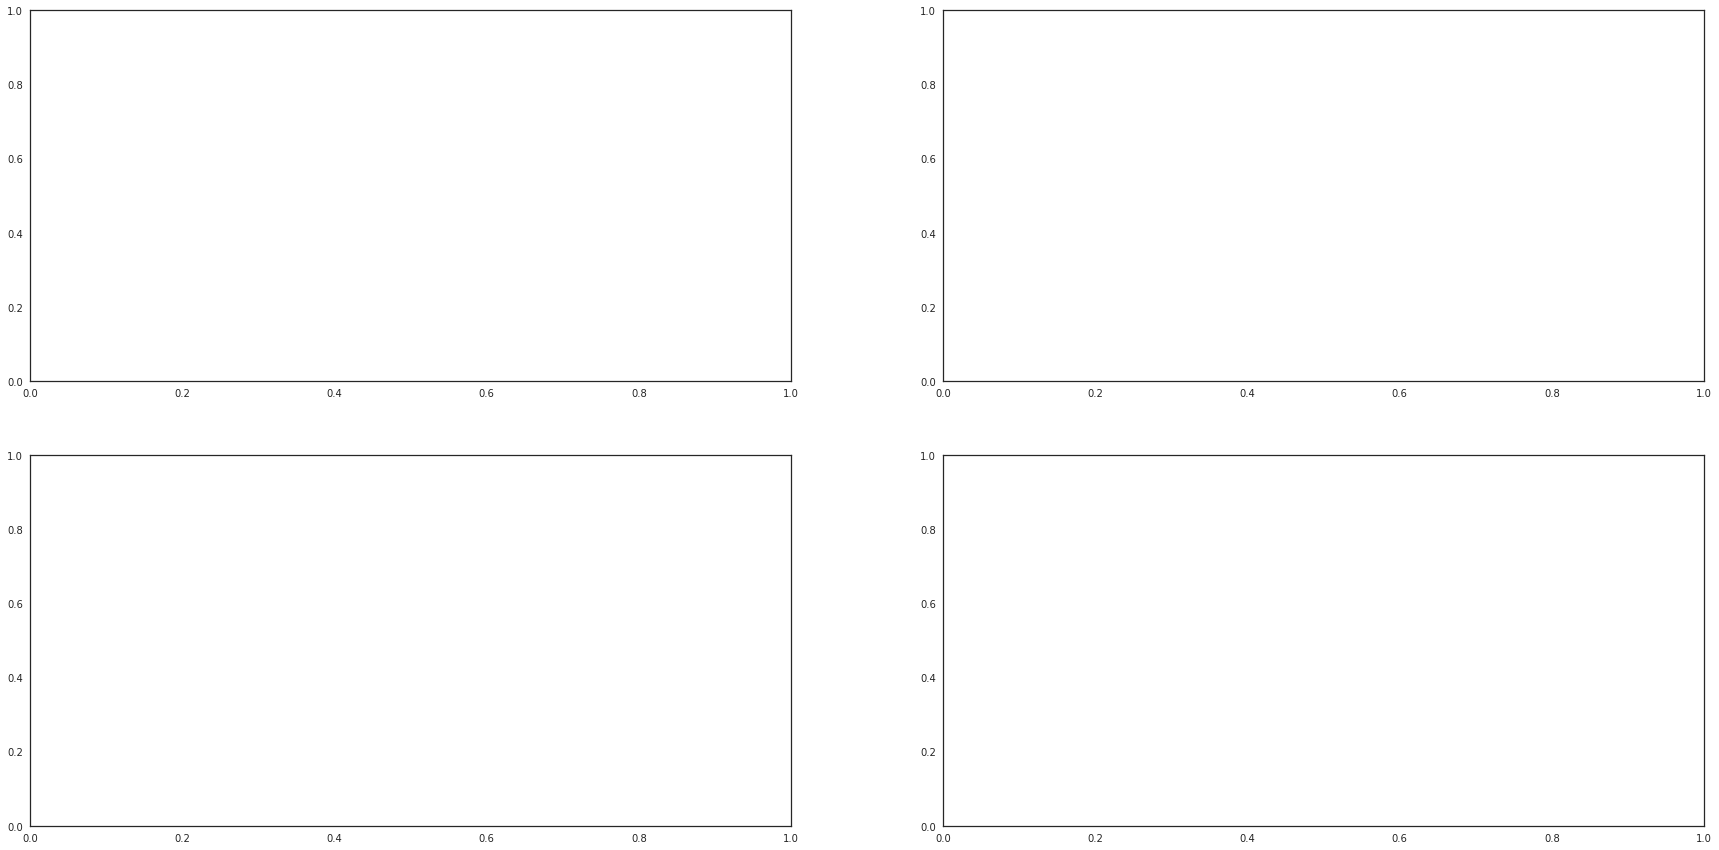

In [196]:
fig,axes = plt.subplots(2, 2, figsize=(30, 15))

ax = axes[0, 0]
ax.imshow(generate_wordcloud(women100), interpolation="bilinear")
ax.axis('off')
ax.set_title("Women Top 100", fontsize=30)

ax = axes[0, 1]
ax.imshow(generate_wordcloud(beauty100))
ax.axis('off')
ax.set_title("Beauty Top 100", fontsize=30)

ax = axes[1, 0]
ax.imshow(generate_wordcloud(kids100))
ax.axis('off')
ax.set_title("Kids Top 100", fontsize=30)

ax = axes[1, 1]
ax.imshow(generate_wordcloud(electronics100))
ax.axis('off')
ax.set_title("Electronic Top 100", fontsize=30)

## **Pre-processing:  tf-idf**

tf-idf is the acronym for **Term Frequency–inverse Document Frequency**. It quantifies the importance of a particular word in relative to the vocabulary of a collection of documents or corpus. The metric depends on two factors: 
- **Term Frequency**: the occurences of a word in a given document (i.e. bag of words)
- **Inverse Document Frequency**: the reciprocal number of times a word occurs in a corpus of documents

Think about of it this way: If the word is used extensively in all documents, its existence within a specific document will not be able to provide us much specific information about the document itself. So the second term could be seen as a penalty term that penalizes common words such as "a", "the", "and", etc. tf-idf can therefore, be seen as a weighting scheme for words relevancy in a specific document.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,
                             max_features=180000,
                             tokenizer=tokenize,
                             ngram_range=(1, 2))

In [ ]:
all_desc = np.append(train['item_description'].values, test['item_description'].values)
vz = vectorizer.fit_transform(list(all_desc))

vz is a tfidf matrix where:
* the number of rows is the total number of descriptions
* the number of columns is the total number of unique tokens across the descriptions

In [ ]:
#  create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

Below is the 10 tokens with the lowest tfidf score, which is unsurprisingly, very generic words that we could not use to distinguish one description from another.

In [ ]:
tfidf.sort_values(by=['tfidf'], ascending=True).head(10)

Below is the 10 tokens with the highest tfidf score, which includes words that are a lot specific that by looking at them, we could guess the categories that they belong to: 

In [ ]:
tfidf.sort_values(by=['tfidf'], ascending=False).head(10)

Given the high dimension of our tfidf matrix, we need to reduce their dimension using the Singular Value Decomposition (SVD) technique. And to visualize our vocabulary, we could next use t-SNE to reduce the dimension from 50 to 2. t-SNE is more suitable for dimensionality reduction to 2 or 3. 

### **t-Distributed Stochastic Neighbor Embedding (t-SNE)**

t-SNE is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. The goal is to take a set of points in a high-dimensional space and find a representation of those points in a lower-dimensional space, typically the 2D plane. It is based on probability distributions with random walk on neighborhood graphs to find the structure within the data. But since t-SNE complexity is significantly high, usually we'd use other high-dimension reduction techniques before applying t-SNE.

First, let's take a sample from the both training and testing item's description since t-SNE can take a very long time to execute. We can then reduce the dimension of each vector from to n_components (50) using SVD.

In [ ]:
trn = train.copy()
tst = test.copy()
trn['is_train'] = 1
tst['is_train'] = 0

sample_sz = 15000

combined_df = pd.concat([trn, tst])
combined_sample = combined_df.sample(n=sample_sz)
vz_sample = vectorizer.fit_transform(list(combined_sample['item_description']))

In [ ]:
from sklearn.decomposition import TruncatedSVD

n_comp=30
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_tfidf = svd.fit_transform(vz_sample)

Now we can reduce the dimension from 50 to 2 using t-SNE!

In [ ]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=500)

In [ ]:
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

It's now possible to visualize our data points. Note that the deviation as well as the size of the clusters imply little information  in t-SNE.

In [ ]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600,
                       title="tf-idf clustering of the item description",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [ ]:
combined_sample.reset_index(inplace=True, drop=True)

In [ ]:
tfidf_df = pd.DataFrame(tsne_tfidf, columns=['x', 'y'])
tfidf_df['description'] = combined_sample['item_description']
tfidf_df['tokens'] = combined_sample['tokens']
tfidf_df['category'] = combined_sample['general_cat']

In [ ]:
plot_tfidf.scatter(x='x', y='y', source=tfidf_df, alpha=0.7)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "tokens": "@tokens", "category":"@category"}
show(plot_tfidf)

## **K-Means Clustering**

K-means clustering obejctive is to minimize the average squared Euclidean distance of the document / description from their cluster centroids. 

In [69]:
from sklearn.cluster import MiniBatchKMeans

num_clusters = 20 # need to be selected wisely
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters,
                               init='k-means++',
                               n_init=1,
                               init_size=1000, batch_size=1000, verbose=0, max_iter=1000)

In [50]:
kmeans = kmeans_model.fit(vz)
kmeans_clusters = kmeans.predict(vz)
kmeans_distances = kmeans.transform(vz)

NameError: name 'vz' is not defined

In [ ]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(num_clusters):
    print("Cluster %d:" % i)
    aux = ''
    for j in sorted_centroids[i, :10]:
        aux += terms[j] + ' | '
    print(aux)
    print() 

In order to plot these clusters, first we will need to reduce the dimension of the distances to 2 using tsne: 

In [ ]:
# repeat the same steps for the sample
kmeans = kmeans_model.fit(vz_sample)
kmeans_clusters = kmeans.predict(vz_sample)
kmeans_distances = kmeans.transform(vz_sample)
# reduce dimension to 2 using tsne
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)

In [ ]:
colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
"#e3be38", "#4e2d7c", "#5fdfa8", "#d34690", "#3f6d31", "#d44427", "#7fcdd8", "#cb4053", "#5e9981",
"#803a62", "#9b9e39", "#c88cca", "#e1c37b", "#34223b", "#bdd8a3", "#6e3326", "#cfbdce", "#d07d3c",
"#52697d", "#194196", "#d27c88", "#36422b", "#b68f79"])

In [ ]:
#combined_sample.reset_index(drop=True, inplace=True)
kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
kmeans_df['cluster'] = kmeans_clusters
kmeans_df['description'] = combined_sample['item_description']
kmeans_df['category'] = combined_sample['general_cat']
#kmeans_df['cluster']=kmeans_df.cluster.astype(str).astype('category')

In [ ]:
plot_kmeans = bp.figure(plot_width=700, plot_height=600,
                        title="KMeans clustering of the description",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [ ]:
source = ColumnDataSource(data=dict(x=kmeans_df['x'], y=kmeans_df['y'],
                                    color=colormap[kmeans_clusters],
                                    description=kmeans_df['description'],
                                    category=kmeans_df['category'],
                                    cluster=kmeans_df['cluster']))

plot_kmeans.scatter(x='x', y='y', color='color', source=source)
hover = plot_kmeans.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "category": "@category", "cluster":"@cluster" }
show(plot_kmeans)

## **Latent Dirichlet Allocation**

Latent Dirichlet Allocation (LDA) is an algorithms used to discover the topics that are present in a corpus.

>  LDA starts from a fixed number of topics. Each topic is represented as a distribution over words, and each document is then represented as a distribution over topics. Although the tokens themselves are meaningless, the probability distributions over words provided by the topics provide a sense of the different ideas contained in the documents.
> 
> Reference: https://medium.com/intuitionmachine/the-two-paths-from-natural-language-processing-to-artificial-intelligence-d5384ddbfc18

Its input is a **bag of words**, i.e. each document represented as a row, with each columns containing the count of words in the corpus. We are going to use a powerful tool called pyLDAvis that gives us an interactive visualization for LDA. 

In [ ]:
cvectorizer = CountVectorizer(min_df=4,
                              max_features=180000,
                              tokenizer=tokenize,
                              ngram_range=(1,2))

In [ ]:
cvz = cvectorizer.fit_transform(combined_sample['item_description'])

In [ ]:
lda_model = LatentDirichletAllocation(n_components=20,
                                      learning_method='online',
                                      max_iter=20,
                                      random_state=42)

In [ ]:
X_topics = lda_model.fit_transform(cvz)

In [ ]:
n_top_words = 10
topic_summaries = []

topic_word = lda_model.components_  # get the topic words
vocab = cvectorizer.get_feature_names()

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

In [ ]:
# reduce dimension to 2 using tsne
tsne_lda = tsne_model.fit_transform(X_topics)

In [ ]:
unnormalized = np.matrix(X_topics)
doc_topic = unnormalized/unnormalized.sum(axis=1)

lda_keys = []
for i, tweet in enumerate(combined_sample['item_description']):
    lda_keys += [doc_topic[i].argmax()]

lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
lda_df['description'] = combined_sample['item_description']
lda_df['category'] = combined_sample['general_cat']
lda_df['topic'] = lda_keys
lda_df['topic'] = lda_df['topic'].map(int)

In [ ]:
plot_lda = bp.figure(plot_width=700,
                     plot_height=600,
                     title="LDA topic visualization",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [ ]:
source = ColumnDataSource(data=dict(x=lda_df['x'], y=lda_df['y'],
                                    color=colormap[lda_keys],
                                    description=lda_df['description'],
                                    topic=lda_df['topic'],
                                    category=lda_df['category']))

plot_lda.scatter(source=source, x='x', y='y', color='color')
hover = plot_kmeans.select(dict(type=HoverTool))
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips={"description":"@description",
                "topic":"@topic", "category":"@category"}
show(plot_lda)

In [ ]:
def prepareLDAData():
    data = {
        'vocab': vocab,
        'doc_topic_dists': doc_topic,
        'doc_lengths': list(lda_df['len_docs']),
        'term_frequency':cvectorizer.vocabulary_,
        'topic_term_dists': lda_model.components_
    } 
    return data

*Note: It's a shame that by putting the HTML of the visualization using pyLDAvis, it will distort the layout of the kernel, I won't upload in here. But if you follow the below code, there should be an HTML file generated with very interesting interactive bubble chart that visualizes the space of your topic clusters and the term components within each topic.*

![](https://farm5.staticflickr.com/4536/38709272151_7128c577ee_h.jpg)

In [ ]:
import pyLDAvis

lda_df['len_docs'] = combined_sample['tokens'].map(len)
ldadata = prepareLDAData()
pyLDAvis.enable_notebook()
prepared_data = pyLDAvis.prepare(**ldadata)

<a data-flickr-embed="true"  href="https://www.flickr.com/photos/thykhuely/38709272151/in/dateposted-public/" title="pyLDAvis"><img src="https://farm5.staticflickr.com/4536/38709272151_7128c577ee_h.jpg" width="1600" height="976" alt="pyLDAvis"></a><script async src="//embedr.flickr.com/assets/client-code.js" charset="utf-8"></script>

In [ ]:
import IPython.display
from IPython.core.display import display, HTML, Javascript

#h = IPython.display.display(HTML(html_string))
#IPython.display.display_HTML(h)